# Data Curation Notebook C - Gene Set Annotation

Covers:
- Processing of annotation data
- Biological features
- Analysis of gene sets
- analysis of overlap data


Figures generated:
- Figure 1C
- Figure 1F

Data generated:
- ??

### Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
#import networkx as nx
#import obonet as obo
from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import sys

In [2]:
sys.path.append('/cellar/users/snwright/Git/Network_Evaluation_Tools/neteval/')
from gene_mapper import *

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [4]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/FigureOverlap/'

In [5]:
basedir='/cellar/users/snwright/Data/RareCommon'
annot_dir = os.path.join(basedir, 'Annotations')
input_dir = os.path.join(basedir, 'inputs/March_2025')
keydir= os.path.join(basedir, 'outputs/key_files')
colocdir = os.path.join(basedir, 'outputs/netcoloc/March_2025')
figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/Bio_features'

In [6]:
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

In [7]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

### Load Data

In [8]:
###
over_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/March_2025/RV_GC_overlap.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])

over_df['EFO'] = over_df.trait_pair.apply(lambda x: map_trait_code(x))
over_df['StudyC'] = over_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
over_df['StudyR'] = over_df.trait_pair.apply(lambda x: x.split('_')[0])
over_df['Expected'] = over_df.n_rare * over_df.n_common / 19000
over_df['logp'] = -1 * np.log10(over_df['pval'] + 1e-250)

In [9]:
r_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/March_2025', 'rare_Mar28.traitlist'), header=None)[0].values
c_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/March_2025', 'common_Mar28.traitlist'), header=None)[0].values
pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]

## Annotation Data Processing

### Mutational Constraint

- LOEUF
    * -lof.oe_ci.upper: LOEUF: upper bound of 90% confidence interval for o/e ratio for high confidence pLoF variants (lower values indicate more constrained)
- Synonymous intolerance

In [10]:
def prioritize_gene_duplicates(df, gene, score_cols):
    """Where there are multiple distinct entries for a gene, we first prioritize those representing canonical transcripts. 
    If there are multiple or no canonical transcripts we next prioritize MANE Select transcripts. Where these filters are 
    unable to produce a single gene entry, we prioritize the entry assigned an NCBI Gene ID. """
    # sort such that NCBI Gene IDs will be first
    gene_df = df[df.gene==gene].sort_values('gene_id')
    if len(gene_df) == 0:
        return None
    # if there is only one entry, take this entry
    if len(gene_df)==1:
        return gene_df.index.values[0]
    # if there are multiple entries
    else:
        # if all entries have the same scores, take the first ID (will be NCBI Gene ID if available)
        if len(gene_df.drop_duplicates(subset=score_cols)) == 1:
            # results are all the same anyway. Return the entry with entrez id
            return gene_df.index.values[0]
        
        # Otherwise, we need to prioritize amongst the results
        else:
            # is there at least one canonical transcript
            if len(gene_df[(gene_df.canonical)]) >= 1:
                gene_df = gene_df[gene_df.canonical]
                
            # is there at least one mane select transcript
            if len(gene_df[(gene_df.mane_select)]) >= 1:
                gene_df = gene_df[gene_df.mane_select]
                
            # at this point all entries should have the same values for canonical and mane_select
            # check if these prioritizations have left us with just one entry
            if len(gene_df) == 1:
                return gene_df.index.values[0]
            
            # check if there are any duplicates
            dups = gene_df.duplicated(subset=score_cols, keep='first')
            if sum(dups) > 0:
                # take the duplicated values as the correct ones.
                return gene_df[~dups].index.values[0]
            
            # any dfs making it here have different scores, but same transcript designations
            return gene_df.index.values[0]

                
 

#### LOEUF

In [11]:
pli_df = pd.read_csv(os.path.join(refdir, 'gnomAD', 'gnomad.v4.1.constraint_metrics.tsv'), sep='\t',
                    usecols=['gene', 'gene_id', 'canonical','mane_select', 'lof.z_score', 'lof.pLI', 'lof_hc_lc.pLI','lof.oe_ci.upper' ])
# exclude non-canonical transcripts
print(pli_df.gene.nunique())

NameError: name 'refdir' is not defined

In [ ]:
out = []
for gene in tqdm(pli_df.gene.unique()):
    out.append(prioritize_gene_duplicates(pli_df, gene, score_cols=['lof.pLI', 'lof.z_score', 'lof_hc_lc.pLI', 'lof.oe_ci.upper']))

In [12]:
gene_pli = pli_df.iloc[out[:-1], :]

NameError: name 'pli_df' is not defined

Map identifiers to NCBI Gene IDs

In [ ]:
print('# Ensembl IDs:', len(gene_pli[~gene_pli.gene_id.str.isnumeric()]))

In [ ]:
gene_map = pli_df.loc[pli_df.gene_id.str.isnumeric(), ('gene', 'gene_id')].merge(gene_pli[~gene_pli.gene_id.str.isnumeric()], on='gene', suffixes=('', 'x'), how='right').drop_duplicates(subset=['gene'])
gene_pli = pd.concat([gene_pli[gene_pli.gene_id.str.isnumeric()], gene_map])#.drop(columns=['gene_idx', 'canonical', 'mane_select'])

In [ ]:
missing_pli = gene_pli[gene_pli.gene_id.isna()]
missing_sym = gene_pli[gene_pli.gene_id.isna()]['gene'].values

In [ ]:
updated_symb, missing = update_nodes(missing_sym, 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symb.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))
missing_pli['gene_id'] = missing_pli.gene.apply(lambda x: converted_ids[updated_symb[x]])

In [ ]:
gene_pli = pd.concat([gene_pli, missing_pli ])
gene_pli = gene_pli.drop_duplicates(subset=['gene_id', 'lof.oe_ci.upper'])
print(len(gene_pli), gene_pli.gene_id.nunique())

In [ ]:
gene_pli = gene_pli.drop(columns=['gene_idx', 'canonical', 'mane_select'])
gene_pli.columns = ['Symbol', 'Entrez', 'lof_hc_lc.pLI', 'lof.pLI', 'lof.z_score', 'LOEUF']
gene_pli.loc[:, ('Entrez', 'LOEUF')].to_csv(os.path.join(outdir, 'Gene_pLI.txt'), index=False, sep='\t')

#### Synonymous Intolerance

-syn.z_score: Z-score for synonymous variants in transcript. Higher (more positive) Z scores indicate that the transcript is more intolerant of variation (more constrained).

In [ ]:
mis_df = pd.read_csv(os.path.join(refdir, 'gnomAD', 'gnomad.v4.1.constraint_metrics.tsv'), sep='\t',
                    usecols=['gene', 'gene_id', 'canonical','mane_select', 'mis.z_score', 'syn.z_score'])
# exclude non-canonical transcripts
print(mis_df.gene.nunique())

In [ ]:
out = []
for gene in tqdm(mis_df.gene.unique()):
    out.append(prioritize_gene_duplicates(mis_df, gene, score_cols=['mis.z_score', 'syn.z_score']))

In [ ]:
gene_mis = mis_df.iloc[out[:-1], :]
len(gene_mis)

Map indentifiers to NCBI Gene IDs

In [ ]:
# replace with NCBI IDs as needed
print('# Ensembl IDs:', len(gene_mis[~gene_mis.gene_id.str.isnumeric()]))

In [ ]:
gene_map = mis_df.loc[mis_df.gene_id.str.isnumeric(), ('gene', 'gene_id')].merge(gene_mis[~gene_mis.gene_id.str.isnumeric()], on='gene', suffixes=('', 'x'), how='right').drop_duplicates(subset=['gene'])
gene_mis = pd.concat([gene_mis[gene_mis.gene_id.str.isnumeric()], gene_map]).drop(columns=['gene_idx', 'canonical', 'mane_select'])
gene_mis.columns = ['Symbol', 'Entrez', 'mis.z_score', 'syn.z_score']

In [ ]:
gene_mis.loc[:, ('Entrez', 'syn.z_score')].to_csv(os.path.join(outdir, 'Gene_MisSyn.txt'), index=False, sep='\t')

### mRNA Expression

- Average expression
- Number of expressed tissues

In [ ]:
rna_raw = pd.read_csv(os.path.join(refdir, 'gtex_median_processed_1.tsv.gz'), sep='\t')
rna_df = rna_raw[~rna_raw.Entrez.isna()].drop(columns=['Ensembl_ID', 'Symbol']).set_index('Entrez')

In [ ]:
rna_metrics = pd.DataFrame({'Mean_mRNA':rna_df.mean(axis=1), 'n_Expressed':(rna_df > 1).sum(axis=1)}).reset_index()

In [ ]:
rna_metrics = rna_metrics.sort_values(by='Mean_mRNA', ascending=False).drop_duplicates(subset='Entrez', keep='first')

In [ ]:
rna_metrics.to_csv(os.path.join(outdir, 'Gene_mRNA.txt'), sep='\t', index=False)

### GO Annotations

In [ ]:
go_df = pd.read_csv(os.path.join(refdir, 'gene2go.gz'), sep='\t')
go_df = go_df[go_df['#tax_id']==9606].drop(columns=['#tax_id'])

In [ ]:
# remove negating qualifiers
exclude_qualifiers = [x for x in go_df.Qualifier.unique() if 'NOT' in x]
go_df = go_df[~go_df.Qualifier.isin(exclude_qualifiers)]

In [ ]:
go_counts = go_df.groupby(['GeneID', 'Category']).GO_ID.nunique().reset_index()
go_counts = go_counts.pivot_table(index='GeneID', columns=['Category'], values='GO_ID', fill_value=0).reset_index()
go_counts.columns = ['Entrez', 'n_GO_CC', 'n_GO_MF', 'n_GO_BP']
go_counts['n_GO']=go_counts['n_GO_CC'] + go_counts['n_GO_MF'] + go_counts['n_GO_BP']

In [ ]:
go_counts.to_csv(os.path.join(outdir, 'Gene_GO.txt'), sep='\t', index=False)

### Gene length

In [ ]:
length_df = pd.read_csv(os.path.join(refdir,'Ensembl_Feb14_2025.txt.gz'), sep='\t', low_memory=False,
                       usecols=['Gene stable ID', 'Gene start (bp)', 'Gene end (bp)', 'Chromosome/scaffold name',
                               'NCBI gene (formerly Entrezgene) ID', 'HGNC symbol'],
                       )
length_df.columns = ['Ensembl', 'Start', 'End', 'Chrom', 'Entrez', 'Symbol']
length_df = length_df.dropna(subset=['Start', 'End', 'Entrez']).drop_duplicates()
length_df = length_df[length_df.Chrom.isin([str(x) for x in range(1, 23)] + ['X', 'Y'])]
length_df = length_df[~length_df.Symbol.isna()]
length_df['GeneSize'] = length_df['End'] - length_df['Start']

Map indentifiers to NCBI Gene IDs

In [ ]:
updated_symbols, missing = update_nodes(length_df.Symbol.unique(), 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symbols.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))

In [ ]:
gene_map = {x: converted_ids[y] for x,y in updated_symbols.items()}
length_df = length_df.assign(Entrez = length_df.Symbol.map(gene_map))
# remove duplicated gene lengths
length_df = length_df.drop_duplicates(subset=['Entrez', 'GeneSize'])

In [ ]:
print('Genes with conflicting entries:',  length_df[length_df.Entrez.duplicated(keep=False)].Entrez.nunique())
# Remove genes with conflicting entries
length_df = length_df[~length_df.Entrez.isin(length_df[length_df.Entrez.duplicated(keep=False)].Entrez.values)]
print('Final size:', len(length_df))

In [ ]:
length_df.sort_values('Entrez').loc[:, ('Entrez','Chrom', 'Start', 'End', 'GeneSize')].to_csv(os.path.join(outdir, 'Gene_length.txt'), sep='\t', index=False)

## Collate Annotations

In [13]:
files = { 'MisSyn': 'Gene_MisSyn.txt',  'pli': 'Gene_pLI.txt',
    'Length': 'Gene_length.txt',
    'GO': 'Gene_GO.txt' ,
    'mrna':'Gene_mRNA.txt', 'n_mrna':'Gene_mRNA.txt'
}  

In [14]:
missing_val = {
 'GO': 0,
}

usecols = {
 'MisSyn': 'syn.z_score',
 'pli': 'LOEUF',
 'Length': 'GeneSize',
 'GO': 'n_GO',
 'mrna': 'Mean_mRNA', 
 'n_mrna': 'n_Expressed'}

labels = {
 'MisSyn': 'Synonymous intolerance',
 'pli': 'Med. LOEUF',
 'Length': 'Med. Gene Size',
 'GO': 'Med. GO Terms',
 'mrna': 'mRNA Exp.', 
 'n_mrna': 'Med. Exp. Tissues'}

In [15]:
annot_dfs = {}
for met, file in files.items():
    annot_dfs[met] = pd.read_csv(os.path.join(annot_dir, file), sep='\t', index_col=0, usecols=['Entrez']+[usecols[met]]).dropna()
    annot_dfs[met] = annot_dfs[met][~annot_dfs[met].index.isna()]
    annot_dfs[met].index = annot_dfs[met].index.astype(int)
    print(met, annot_dfs[met].shape)

MisSyn (18075, 1)
pli (17954, 1)
Length (25013, 1)
GO (20739, 1)
mrna (34812, 1)
n_mrna (34812, 1)


In [16]:
bio_df = annot_dfs['MisSyn']
for met, df in annot_dfs.items():
    if met != 'MisSyn':
        bio_df = bio_df.join(annot_dfs[met], how='outer')
bio_df = bio_df.dropna(thresh=2)
#bio_df = bio_df.fillna({usecols[k]:missing_val[k] for k in missing_val})
bio_df = bio_df.rename(columns={usecols[k]:k for k in usecols})

In [17]:
bio_df.to_csv(os.path.join(keydir, 'Features_bio_gene_test.txt'), sep='\t')

## Gene Set Annotations

In [18]:
r_traitlist = set()
c_traitlist = set()

with open(os.path.join(input_dir, 'best_rare.traitlist'), 'r') as f:
    r_traitlist = r_traitlist.union(set([x.strip() for x in f.readlines()]))
with open(os.path.join(input_dir, 'not_best_rare.traitlist'), 'r') as f:
    r_traitlist = r_traitlist.union(set([x.strip() for x in f.readlines()]))
    
with open(os.path.join(input_dir, 'best_common.traitlist'), 'r') as f:
    c_traitlist = c_traitlist.union(set([x.strip() for x in f.readlines()]))
with open(os.path.join(input_dir, 'not_best_common.traitlist'), 'r') as f:
    c_traitlist = c_traitlist.union(set([x.strip() for x in f.readlines()]))
print(len(r_traitlist), len(c_traitlist))

536 947


In [19]:
rare_annot = {}
for gs in tqdm(list(r_traitlist)):
    genes = pd.read_csv(os.path.join(input_dir, f'{gs}_RV.txt'), sep='\t').Entrez.values
    genes = [x for x in genes if x in bio_df.index.values]
    gene_df = bio_df.loc[genes, :]
    gene_df = gene_df.fillna(missing_val)
    #gene_df = gene_df.dropna(axis=1, thresh=)
    rare_annot[gs] = gene_df.median(axis=0).to_dict()

100%|██████████| 536/536 [00:03<00:00, 140.29it/s]


In [20]:
common_annot = {}
for gs in tqdm(list(c_traitlist)):
    genes = pd.read_csv(os.path.join(input_dir, f'{gs}_CV.txt'), sep='\t').Entrez.values
    genes = [x for x in genes if x in bio_df.index.values]
    gene_df = bio_df.loc[genes, :]
    gene_df = gene_df.fillna(missing_val)
    #gene_df = gene_df.dropna(axis=1, thresh=3)
    common_annot[gs] = gene_df.median(axis=0).to_dict()

100%|██████████| 947/947 [00:06<00:00, 144.99it/s]


In [21]:
rare_df = pd.DataFrame(rare_annot).T
rare_df['Set'] = 'Rare'
common_df = pd.DataFrame(common_annot).T
common_df['Set'] = 'Common'

In [22]:
rc_df= pd.concat([rare_df, common_df])

In [23]:
rc_df.to_csv(os.path.join(keydir, 'Features_bio_genesets_test.txt'), sep='\t')

In [24]:
initial_df = pd.read_csv(os.path.join(keydir, 'initial_coloc_overlap.txt'), sep='\t')
repeat_df = pd.read_csv(os.path.join(keydir, 'repeat_coloc_overlap.txt'), sep='\t')
best_df = pd.read_csv(os.path.join(keydir, 'best_coloc_overlap.txt'), sep='\t')
coloc_df = pd.concat([initial_df, repeat_df])
coloc_df.columns

Index(['TraitR', 'TraitC', 'Network', 'Transform', 'Norm', 'Mean_NPS',
       'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size',
       'logp_nps', 'logp_size', 'log2SizeOE', 'EFO', 'Set', 'trait_pair', 'q',
       'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'],
      dtype='object')

In [25]:
initial_trait_pairs = list(initial_df.trait_pair.values)
initial_r_traits = list(initial_df.TraitR.values)
initial_c_traits = list(initial_df.TraitC.values)

In [26]:
rc_initial = rc_df.loc[initial_r_traits+initial_c_traits]

In [27]:
study_df = pd.read_csv(os.path.join(keydir, 'all_study_info.txt'), sep='\t', index_col=0)
study_df['N_C'] = study_df.apply(lambda x: x.N_C if x['PUBMED ID']!=34610981 else 5705, axis=1)
domain_info = pd.read_csv(os.path.join(keydir, 'domain_trait_type.txt'), sep='\t', index_col=0).drop_duplicates()
best_df = best_df.merge(domain_info.loc[:, ('EFO', 'Domain')], on=['EFO'], how='left')
coloc_df = coloc_df.merge(domain_info, on=['EFO'], how='left')
best_df = coloc_df[coloc_df.trait_pair.isin(best_df.trait_pair.values)]
best_pairs = best_df.trait_pair.values
all_pairs = coloc_df.trait_pair.values

In [28]:
input_df = study_df.loc[:, ('trait_pair', 'N_R', 'N_C', 'Cosine_R', 'Cosine_C')].set_index('trait_pair').join(coloc_df.loc[:, 
                                        ('trait_pair', 'log2SizeOE','logp_size', 'n_common', 'n_rare', 
                                         'n_overlap', 'pval', 'trait_type')].set_index('trait_pair'))
input_df['jaccard'] = input_df.apply(lambda x: (x.n_overlap/(x.n_common+x.n_rare-x.n_overlap)), axis=1)
input_df['binary'] = input_df.trait_type.apply(lambda x: 1 if x=='CC' else 0)
input_df['jaccard_zero'] = input_df.jaccard.apply(lambda x: 1 if x ==0  else 0)
input_df['Gene_ratioRC']= input_df.apply(lambda x: x.n_rare/x.n_common, axis=1)
input_df['overlap_logp'] = input_df.pval.apply(lambda x: -1 * np.log10(x + 1e-250))

In [29]:
input_initial= input_df.reset_index().loc[input_df.reset_index().trait_pair.isin(initial_trait_pairs), ['N_R', 'N_C', 'n_common', 'n_rare', 'trait_pair']]

input_initial = input_initial.assign(TraitR = input_initial.trait_pair.apply(lambda x: x.split('_GCST')[0]))
input_initial = input_initial.assign(TraitC = input_initial.trait_pair.apply(lambda x: 'GCST' + x.split('_GCST')[-1]))
input_initial = input_initial.melt(id_vars=['trait_pair', 'TraitR', 'TraitC'])
input_initial = input_initial.assign(Set = input_initial.variable.apply(lambda x: 'Rare' if (x=='N_R') or (x=='n_rare') else 'Common'),
                                    metric = input_initial.variable.apply(lambda x: 'N' if 'N' in x else 'n'))
input_initial = input_initial.pivot(index=['trait_pair', 'Set', 'TraitR', 'TraitC'], columns='metric', values='value').reset_index()
input_initial = input_initial.assign(trait = input_initial.apply(lambda x:  x.TraitR if x.Set=='Rare' else x.TraitC, axis=1)).drop(columns=['TraitR', 'TraitC'])
input_initial = input_initial.set_index('trait')
input_initial.index.name=''
input_initial.columns.name=''

In [30]:
input_df.to_csv(os.path.join(keydir, 'Features_input_test.txt'), sep='\t')

In [31]:
all_rc_initial = input_initial.join(rc_initial.drop(columns=['Set']))

In [32]:
def do_paired_test(rc_df, metric=np.median):
    print('Diff < 0 = rare is higher')
    overall_res = {}
    
    for met in rc_df.columns:
        if met not in ['Set', 'trait_pair']:
            test_df = rc_df.loc[:, ('Set', 'trait_pair', met)].pivot(index='trait_pair', columns='Set', values=met).dropna().reset_index()
            median_diff = np.median(test_df.Rare.values - test_df.Common.values)
            res = wilcoxon(test_df.Rare.values - test_df.Common.values)
            overall_res[met] = {'Diff':median_diff, 'p':res.pvalue}
    overall_res = pd.DataFrame(overall_res).T
    overall_res['q'] = fdrcorrection(overall_res.p)[1]
    overall_res['sig'] = overall_res.q < 0.05
    return overall_res

In [33]:
paired_res = do_paired_test(all_rc_initial)

Diff < 0 = rare is higher


In [34]:
print('Median Population Sample Sizes')
all_rc_initial.groupby('Set').N.median()

Median Population Sample Sizes


Set
Common    136016.0
Rare      209319.0
Name: N, dtype: float64

In [35]:
paired_res

,Diff,p,q,sig
N,-37117.000000,3.380602e-08,9.014938e-08,True
n,5.000000,6.235698e-04,8.314265e-04,True
MisSyn,-0.010966,5.634648e-01,5.634648e-01,False
pli,-1.148475,1.038547e-33,4.154187e-33,True
Length,-45367.500000,1.256413e-51,1.005130e-50,True
GO,-1.500000,1.443852e-05,2.887704e-05,True
mrna,-0.588599,4.314782e-01,4.931179e-01,False
n_mrna,-0.500000,3.674170e-04,5.878673e-04,True


In [36]:
# need a list of protein coding genes IDed by Entrez.
coding_genes = pd.read_csv(os.path.join(basedir, 'Reference/Ensembl_Feb14_2025.txt.gz'), sep='\t', usecols=['Gene type', 'NCBI gene (formerly Entrezgene) ID'])
coding_genes = coding_genes[coding_genes['Gene type']=='protein_coding'].dropna().drop_duplicates()
coding_genes.columns=['Gene type', 'Entrez']
coding_genes.Entrez = coding_genes.Entrez.astype(int)
coding_df = bio_df.loc[[x for x in coding_genes.Entrez.values if x in bio_df.index.values]]

### Figure 1C

In [37]:
def plot_r_vs_c_violin2(rc_df, overall_res, labels):
    n_sig = len(overall_res)
    _ , axs = plt.subplots(nrows=1, ncols=n_sig, figsize=(n_sig, 1.25), gridspec_kw={'wspace':0.8})
    for i, met in enumerate(overall_res.index.values):
    #plot_median = bio_df[met].dropna().median()
        if met in ['Length', 'CDS', 'mrna', 'Cite', 'N', 'n']:
            sns.violinplot(rc_df, x='Set', y=met, cut=0, ax=axs[i], log_scale=True, hue_order=['Common', 'Rare'],
                           saturation=1, zorder=2, linewidth=0.5, hue='Set', palette=[blue, green])

        else:
            sns.violinplot(rc_df, x='Set', y=met, cut=0, ax=axs[i], log_scale=False, hue_order=['Common', 'Rare'],
                           saturation=1, zorder=2, linewidth=0.5, hue='Set', palette=[blue, green])

        _ = axs[i].set_xlabel('')
        _ = axs[i].set_ylabel(labels[met])
        if overall_res.at[met, "q"] < 1e-5:
            s= '***'
        elif overall_res.at[met, "q"] < 1e-3:
            s='**'
        elif overall_res.at[met, "q"] < 0.05:
            s='*'
        else:
            s='n.s.'
        axs[i].set_title(f'{s}', fontsize=7)
        axs[i].tick_params(axis='x', rotation=30)
        out_ax1 = axs
    return out_ax1

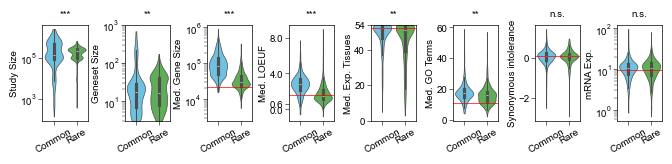

In [40]:
ax1= plot_r_vs_c_violin2(all_rc_initial, paired_res.loc[['N', 'n', 'Length', 'pli', 'n_mrna','GO','MisSyn', 'mrna']], 
                              labels={**labels, 'N':'Study Size', 'n': 'Geneset Size'})
ax1[2].hlines(y=bio_df.Length.median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[2].set_ylim(2500, 1.2e6)
ax1[1].set_ylim(3, 1000)
ax1[3].hlines(y=coding_df.pli.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[4].hlines(y=coding_df.n_mrna.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[5].hlines(y=coding_df.GO.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[6].hlines(y=coding_df.MisSyn.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[7].hlines(y=coding_df.mrna.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
#ax1[1].set_ylim(-0/3, 1.2e6)
for ax in ax1:
    ax.set_xlim(-0.5, 1.5)
    
_ = ax1[3].set_yticks([0,0.6,4,8])
_ = ax1[4].set_yticks([0, 20, 40, 54])
ax1[4].set_ylim(0, 54)
plt.savefig(os.path.join(figdir, 'gene_set_features_fig1.svg'), bbox_inches='tight')


## CV & RV Overlaps

In [9]:
top_over_df = over_df[over_df.trait_pair.isin(pairs)]
top_over_df['q'] = fdrcorrection(top_over_df.pval.values)[1]
top_over_df['J'] = top_over_df.n_overlap / (top_over_df.n_common + top_over_df.n_rare - top_over_df.n_overlap)

In [31]:
print('Trait with highest CV-RV similarity:')
print(top_over_df.sort_values('J', ascending=False).iloc[0].loc[['EFO', 'n_rare', 'n_common', 'n_overlap', 'logq']])

Trait with highest CV-RV similarity:
EFO          EFO_0007805
n_rare                17
n_common              22
n_overlap             11
logq           31.268479
Name: 152, dtype: object


In [50]:
print('Traits with no shared genes:', len(top_over_df[top_over_df.n_overlap==0]))
print('Traits with significant number of shared genes:', len(top_over_df[(top_over_df.n_overlap>0) & (top_over_df.q <0.05)]))

Traits with no shared genes: 189
Traits with significant number of shared genes: 184


In [13]:
top_over_df['rare_only'] = top_over_df.n_rare - top_over_df.n_overlap
top_over_df['common_only'] = top_over_df.n_common - top_over_df.n_overlap
top_over_df['total'] = top_over_df.rare_only + top_over_df.common_only + top_over_df.n_overlap
top_over_df['overlap+rare'] = top_over_df.n_overlap + top_over_df.rare_only
top_over_df = top_over_df.sort_values(by=['n_overlap', 'total'], ascending=False)

In [14]:
top_over_df['logq'] = top_over_df.q.apply(lambda x: -1 * np.log10(x+1e-50))

In [15]:
plot_df=top_over_df[(top_over_df.param_set=='defaults') & ((top_over_df.total > 100) ) & (top_over_df.total < 1000)].melt(id_vars=['trait_pair', 'q', 'logq'], value_vars=['n_overlap', 'overlap+rare', 'total'])
total_order = top_over_df[top_over_df.param_set=='defaults'].sort_values(by=['n_overlap', 'n_rare', 'n_common'], ascending=[False, False, False]).trait_pair.values

### Figure 1F

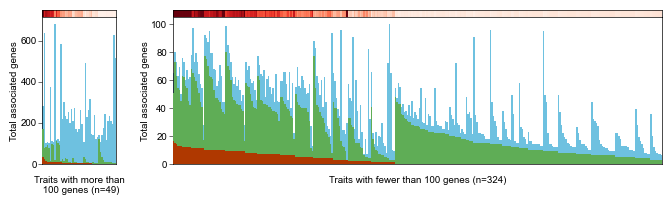

In [17]:
_, [[ax1a, ax2a], [ax1, ax2]] = plt.subplots(2, 2, figsize=(8, 2), sharex=False, 
                                             gridspec_kw={'height_ratios': [1, 20], 'width_ratios':[49,324], 'hspace': 0})



order = [x for x in total_order if x in plot_df.trait_pair.values]
n1=len(order)
#plot_df[plot_df.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair
sns.heatmap(np.array(plot_df[plot_df.variable=='total'].set_index('trait_pair').loc[order]['logq']).reshape(-1, 1).T,
            ax=ax1a, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False,vmax=25, vmin=0)

sns.barplot(plot_df[plot_df.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', zorder=10, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', zorder=5, order=order,
            saturation=1,  ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', zorder=1, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
ax1.set_xticks([])


plot_df2 =top_over_df[(top_over_df.param_set=='defaults')  & (top_over_df.total <= 100)].melt(id_vars=['trait_pair', 'q', 
                                                                                                       'logq'], 
                                                                  value_vars=['n_overlap', 'overlap+rare', 'total'])
order = [x for x in total_order if x in plot_df2.trait_pair.values]
#plot_df2[plot_df2.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair

n2=len(order)
sns.heatmap(np.array(plot_df2[plot_df2.variable=='total'].set_index('trait_pair').loc[order]['logq']).reshape(-1, 1).T, 
            ax=ax2a, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df2[plot_df2.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', 
            zorder=10, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', 
            zorder=5, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', 
            zorder=1, order=order, ax=ax2, alpha=1, saturation=1, width=1)
ax2.set_xticks([])
ax1.set_xlabel(f'\nTraits with more than\n 100 genes (n={n1})')
ax2.set_xlabel(f'\nTraits with fewer than 100 genes (n={n2})')
_ = ax1.set_ylabel('Total associated genes')
_ = ax2.set_ylabel('Total associated genes')

for ax in [ax1a, ax2a]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        
plt.savefig(os.path.join(figdir, 'overlap_summary_gcat.svg'), dpi=400, bbox_inches='tight')

In [52]:
top_over_df_sig = top_over_df[(top_over_df.q<0.05) & (top_over_df.n_overlap>0)]

In [65]:
print('Median percent of CVGs shared:', f'{100*(top_over_df_sig["n_overlap"]/top_over_df_sig["n_common"]).median():.1f}%')

Median percent of CVGs shared: 27.5%


In [66]:
print('Median percent of RVGs shared:', f'{100*(top_over_df_sig["n_overlap"]/top_over_df_sig["n_rare"]).median():.1f}%')

Median percent of RVGs shared: 18.3%
